In [2]:
# python basic pacakages
import aifc
import os
import datetime
from os import listdir
from os.path import isfile, join
import csv

# required packags
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# my packages
from DataManager.Audio import *
from DataManager.General import *

In [2]:
# labels_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train.csv"
# train_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train"

labels_path = "data/train.csv"
train_path = "data/train"
redux_train_path = "data/train2"

audiofiles = [os.path.join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
audiofiles_redux = [os.path.join(redux_train_path, f) 
                    for f in listdir(redux_train_path) if isfile(join(redux_train_path, f))]

limitator = None

In [ ]:
labels_dict = get_labels(labels_path)

seconds_in_sound = 1.7
p_cut = seconds_in_sound/2
top_hz = 50

kwargs = {'p': p_cut, 'top_hz': top_hz}

# Get a random permutation to remove ordering bias
np.random.shuffle(audiofiles)

# convert the list of files to numpy arrays and select a random smaller version if limitador is not None
X_path = np.array(audiofiles)[:limitator]

# Start the process of data extraction, spectrogram transformation and data enhancement
print('Generating train and test split')
X_train_path, X_test_path = train_test_split(X_path, test_size=0.05)

print('Getting test spectrograms')
X_test, Y_test = get_spects(X_test_path, labels_dict, **kwargs)

# print('Getting test spectrograms')
# X_train, Y_train = get_spects(X_train_path, labels_dict)

print('Getting train spectrograms + enhancement')
X_train, Y_train = get_spects_enhanced(X_train_path, labels_dict, **kwargs)

print('Getting even more data adding noise to whale calls')
X_enhanced, Y_enhanced = enhance_with_noise(X_train, Y_train)

X_train, Y_train = np.concatenate([X_train, X_enhanced]), np.concatenate([Y_train, Y_enhanced])

print('Test', X_test.shape)

print('Train', X_train.shape)


Generating train and test split
Getting test spectrograms
Getting train spectrograms + enhancement


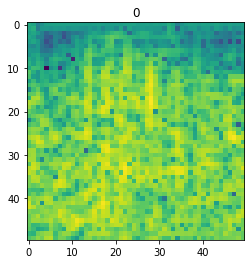

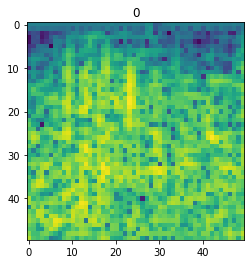

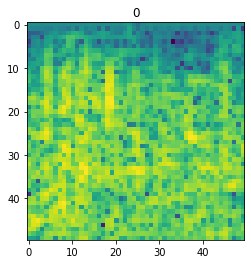

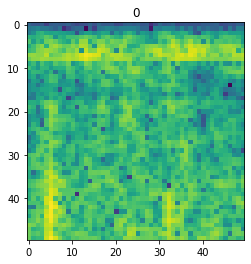

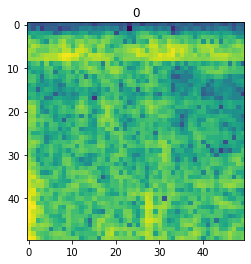

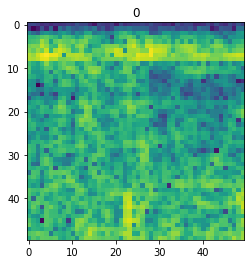

2.961951914530217
7.742528019848882 -4.493678527214692


In [4]:
def f(x):
    return np.log(x + 1e-7)
    
for i in range(X_train.shape[0]):
    n_index = i
    X_train_t = np.array(list(map(f, X_train)))
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        print(X_train_t[n_index].max(), X_train_t[n_index].min())
        break

In [ ]:
from librosa.feature import melspectrogram

def f(x):
    return x

def f_mel(x):
    return melspectrogram(S=x)

X_train_t = np.array(list(map(f_mel, X_train)))

for i in range(X_train.shape[0]):
    n_index = i
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        print(X_train_t[n_index].max())
        print(X_train_t[n_index].min())
        
        break

## Normalize small

In [ ]:

# def imagery(x, new_shape, top_hz):

#     return np.array(Image.fromarray(X_train[0][:top_hz]).convert("L").resize(new_shape))

def f(x):
    return x / x.max()

def log_norm(x):
    log_spect = np.log(x + 1)
    return log_spect / log_spect.max()

def f_05(x):
    x_min = x.min()
    return (x - x_min) / (x.max() - x_min) - .5


def f_norm(x):
    x_min = x.min()
    return (x - x.mean()) / x.std()
    

X_train = np.array(list(map(log_norm, X_train)))  # lambda x: imagery(x, [32,32], 60), X_train)))
X_test = np.array(list(map(log_norm, X_test)))  # lambda x: imagery(x, [32,32], 60), X_test)))


In [ ]:
print('Test: Whale %.4f, Not Whale %.4f' % ((Y_test == '1').sum() / Y_test.shape[0], 
                                            (Y_test == '0').sum() / Y_test.shape[0]))

print('Train: Whale %.4f, Not Whale %.4f' % ((Y_train == '1').sum()  / Y_train.shape[0], 
                                             (Y_train == '0').sum()  / Y_train.shape[0]) )

In [ ]:
'Tamaño en memoria de los datos de training aprox: %.2fGB' % (X_train.nbytes/2**10/2**10/2**10)

In [ ]:
def create_base_network(input_shape, kernel_size=(6,6), final_dimension=12, regularization=0.011):
    # model building
    model = tf.keras.models.Sequencial()
    # convolutional layer with rectified linear unit activation
    # flatten since too many dimensions, we only want a classification output
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                     activation='relu',
                     input_shape=input_shape, kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                    activation='relu', kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    # things to test in order to increase the performance of the mdel
    # play a little with the kernel sizes - test values: (6,6)
    # change the optimization function - 
    model.add(tf.keras.models.Flatten())
    # embedding sizes with better results seem to be between [8,15[
    model.add(tf.keras.models.Dense(final_dimension, activation='softmax', kernel_initializer=init,
                bias_initializer='zeros'))#13
    print(model.summary())
    return model


class siamese:
    def __init__(self, input_shape, regularization=0.011, kernel_size=(6,6), final_dimension=12, learning_rate=0.0004, margin=1.2):
        self.base_network = create_base_network(input_shape, kernel_size, final_dimension, regularization)

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)

        # because we re-use the same instance `base_network`,
        # the weights of the network
        # will be shared across the two branches
        processed_a = self.base_network(input_a)
        processed_b = self.base_network(input_b)

        distance = Lambda(cosine_distance,  # compare this results with euclidean
                          output_shape=cos_dist_output_shape)([processed_a, 
                          processed_b])

        model = Model([input_a, input_b], distance)

        adam = Adam(lr=learning_rate)
        loss_function = contrastive_loss(margin)
        model.compile(loss=loss_function.loss, optimizer=adam, metrics=[accuracy])
        self.model = model

    def save_base_network(self, k):
        (self.base_network).save_weights("./validation_models/base_network_partition_" + str(k) + ".h5")
        
        
class autoencoder:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1] * X_train.shape[2]]))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu', name='coded_vector'))

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(X_train.shape[1] * X_train.shape[2], activation='sigmoid'))
              
class decoder:
    model = tf.keras.models.Model(inputs=autoencoder.model.input,
                                  outputs=autoencoder.model.get_layer('coded_vector').output)

class winners:
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(20, kernel_size=(7, 7), activation=tf.nn.relu, 
                                   input_shape=X_train.shape[1:], name='Conv1'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation=tf.nn.relu, name='Conv2'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation=tf.nn.relu, name="Dense1"),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax, name="Softmax")
            ])

In [10]:
Y_train, Y_test = Y_train.astype(int), Y_test.astype(int)
Y_train, Y_test = tf.keras.utils.to_categorical(Y_train, 2), tf.keras.utils.to_categorical(Y_test, 2) 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

winners.model.compile(optimizer=opt,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])


print('Training model')
history = winners.model.fit(X_train, Y_train, epochs=10, verbose=1, validation_split=0.3)
score = winners.model.evaluate(X_test, Y_test)


Training model
Train on 54417 samples, validate on 23322 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
54417/54417 [==============================] - 72s 1ms/sample - loss: 0.2528 - acc: 0.8919 - val_loss: 2.8661 - val_acc: 0.4922
Epoch 2/10
54417/54417 [==============================] - 73s 1ms/sample - loss: 0.2334 - acc: 0.9020 - val_loss: 2.2127 - val_acc: 0.5729
Epoch 3/10
54417/54417 [==============================] - 74s 1ms/sample - loss: 0.2415 - acc: 0.9015 - val_loss: 1.8369 - val_acc: 0.5199
Epoch 4/10
54417/54417 [==============================] - 74s 1ms/sample - loss: 0.2417 - acc: 0.9003 - val_loss: 2.0356 - val_acc: 0.5371
Epoch 5/10
54417/54417 [==============================] - 71s 1ms/sample - loss: 0.2415 - acc: 0.9014 - val_loss: 2.4530 - val_acc: 0.5166
Epoch 6/10
54417/54417 [==============================] - 73s 1ms/sample - loss: 0.2433 - acc: 0.9013 - val_loss: 2.9023 - val_acc: 0.5111
Epoch 7/10
54417/54417 [=============================

[0.2551786172257529, 0.899]
Finished at 2019-09-12 13:48:46.258238, saving the results as graphs.


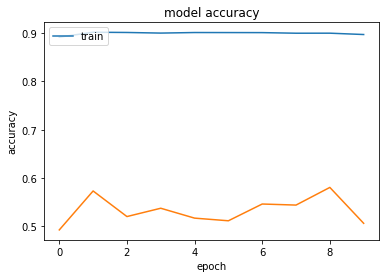

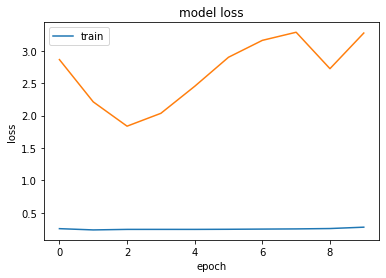

In [12]:
print(score)
print('Finished at {}, saving the results as graphs.'.format(datetime.datetime.now()))

#Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_accuracy' + str(score[1]) + '.pdf')
plt.show()

#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_loss' + str(score[1]) + '.pdf')
plt.show()

In [15]:
#Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
import numpy as np
#Compute probabilities
Y_pred = winners.model.predict(X_test)
#Assign most probable label
y = np.argmax(Y_test, axis=1)
y_hat =  np.argmax(Y_pred, axis=1)
#Plot statistics
print('Analysis of results')
target_names = ['no_whale', 'whale']
print(classification_report(y, y_hat, target_names=target_names))
print(confusion_matrix(y, y_hat))
print(roc_auc_score(y, y_hat))

y_pred_proba = winners.model.predict_proba(X_test)[::,1]



Analysis of results
              precision    recall  f1-score   support

    no_whale       0.91      0.96      0.94      6886
       whale       0.84      0.71      0.77      2114

    accuracy                           0.90      9000
   macro avg       0.88      0.83      0.85      9000
weighted avg       0.90      0.90      0.90      9000

[[6594  292]
 [ 617 1497]]


0.8328656775803591

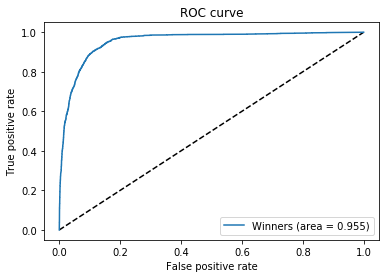

In [27]:
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# y_pred_proba = winners.model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label='Winners (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Submit the results

In [23]:
submission_file = "data/sample_submission.csv"
redux_submission_file = "data/sampleSubmission.csv"
test_path = "data/test"
redux_test_path = "data/test2"

audiofiles_test = [os.path.join(test_path, f) for f in listdir(test_path) if isfile(join(test_path, f))]
audiofiles_redux_test = [os.path.join(redux_test_path, f) 
                    for f in listdir(redux_test_path) if isfile(join(redux_test_path, f))]


In [25]:
audiofiles_test.sort()
audiofiles_test.sort(key=len)

audiofiles_redux_test.sort()
audiofiles_redux_test.sort(key=len)

In [ ]:
def get_submission_spects(onlyfiles, labels, p=0.85, top_hz=-1):

    sps = []
    files = []
    for file_path in onlyfiles:
        s = read_aiff(file_path)
        if s.shape[0] != 4000:
            continue
        s = s[int(s.shape[0] * (1 - p) / 2): int(s.shape[0] * (1 + p) / 2)]
        params = {'NFFT': 256, 'Fs': 2000, 'noverlap': 192}
        sp, freqs, bins = mlab.specgram(s, **params)
        sps.append(sp[:top_hz])
        files.append(file_path.split("/")[-1])
    return np.array(sps), np.array(files)


In [6]:
print('Getting other dataset test spectrograms')
X_test_, files_list = get_spects(audiofiles_redux, labels_dict, p=p_cut, top_hz=top_hz)

['data/test/test52055.aiff',
 'data/test/test11350.aiff',
 'data/test/test40617.aiff',
 'data/test/test36457.aiff',
 'data/test/test31666.aiff',
 'data/test/test43968.aiff',
 'data/test/test34057.aiff',
 'data/test/test21498.aiff',
 'data/test/test34367.aiff',
 'data/test/test36585.aiff',
 'data/test/test6676.aiff',
 'data/test/test49594.aiff',
 'data/test/test9732.aiff',
 'data/test/test36144.aiff',
 'data/test/test6274.aiff',
 'data/test/test22903.aiff',
 'data/test/test3113.aiff',
 'data/test/test54021.aiff',
 'data/test/test41301.aiff',
 'data/test/test25043.aiff',
 'data/test/test10705.aiff',
 'data/test/test14206.aiff',
 'data/test/test9792.aiff',
 'data/test/test48508.aiff',
 'data/test/test10927.aiff',
 'data/test/test30212.aiff',
 'data/test/test29142.aiff',
 'data/test/test3147.aiff',
 'data/test/test47532.aiff',
 'data/test/test22738.aiff',
 'data/test/test35496.aiff',
 'data/test/test2626.aiff',
 'data/test/test18758.aiff',
 'data/test/test3929.aiff',
 'data/test/test19176.

In [ ]:
X_test_ = np.array(list(map(log_norm, X_test_)))
X_test_ = X_test_.reshape(X_test_.shape[0], X_test_.shape[1], X_test_.shape[2], 1)

#Compute labels
Y_pred = model.model.predict(X_test_)
# Assign most probable label
y = np.argmax(Y_test_, axis=1)

In [8]:
pd.DataFrame({'clip': files_list, 'probability': Y_pred[:,1]})

5.0